In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from PIL import Image
import json

In [ ]:
from pycocotools.coco import COCO

In [3]:
from caption import caption_image_beam_search, visualize_att

In [ ]:
coco = COCO('./data/annotations/captions_flickr30k.json')

In [ ]:
img_ids = set()
for k in coco.anns.keys():
    img_ids.add(coco.anns[k]['image_id'])

In [ ]:
images = []
for img_id in img_ids:
    images.append('data/Flickr30k/flickr30k-images/'+coco.loadImgs(img_id)[0]['file_name'])

In [7]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def main(args, test_images, visualize=False):
    
    # Load model
    checkpoint = torch.load(args['model'], map_location=torch.device('cpu'))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()
    
    # Load word map (word2idx)
    with open(args['word_map'], 'r') as j:
        word_map = json.load(j)
        
    # idx2word
    rev_word_map = {v: k for k, v in word_map.items()}  
    
    for i, image_path in enumerate(test_images):
        seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map, 4)
        
        sampled_caption = [rev_word_map[ind] for ind in seq]
        sampled_caption = []
        for ind in seq[1:]:
            word = rev_word_map[ind]
            if word == '<end>':
                break
            sampled_caption.append(word)
            
        sentence = ' '.join(sampled_caption)
        
        # Print out the image and the generated caption
        print (sentence)
        image = Image.open(image_path)
        plt.imshow(np.asarray(image))
        plt.title(sentence)
        plt.xticks([])
        plt.yticks([])
#         plt.savefig('outputs/'+image_path.split('/')[-1])
        plt.show()

        if visualize:
            alphas = torch.FloatTensor(alphas)
            visualize_att(image_path, seq, alphas, rev_word_map)

/Users/apple/miniconda/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/apple/miniconda/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/apple/miniconda/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has c

a man in a blue shirt and black shirt


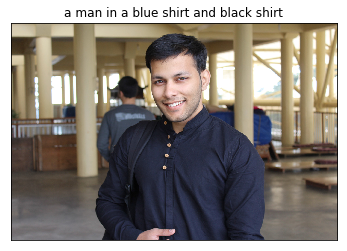

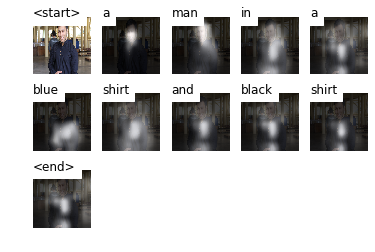

In [8]:
args = {
    'model':'./models/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar',
    'word_map':'./models/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json'
}
test_images = [f'png/test1.jpeg']
main(args, test_images, True)

In [ ]:
args = {
    'model':'./models/BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar',
    'word_map':'./models/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'
}
test_images = images[10:20]
main(args, test_images, True)